In [9]:
from __future__ import print_function, division
import os
import sys
import re
import pdb
import time

import numpy as np
import scipy as sp
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

print('sys_version', sys.version.replace('\n', ''))
print('virtual_env', os.environ.get('VIRTUAL_ENV', 'None'))
print('pwd', os.getcwd())
print('np ', np.__version__)
print('tf ', tf.__version__)

sys_version 3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:53:06) [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
virtual_env None
pwd /home/ante/Documents/NN_face_recognition/nn_devel
np  1.11.2
tf  0.10.0


In [10]:
def square_distance(x, y):
    """
    Computes the squared euclidian distance between two tensorflow variables
    """
    return tf.reduce_sum(tf.square(tf.sub(x, y)), 1)

def triplet_loss(anchor, positive, negative, alpha=0.2):
    """Calculate the triplet loss according to the FaceNet paper
    
    Args:
      anchor: the embeddings for the anchor images.
      positive: the embeddings for the positive images.
      negative: the embeddings for the negative images.
  
    Returns:
      the triplet loss according to the FaceNet paper as a float tensor.
    """
    with tf.variable_scope('triplet_loss'):
        pos_dist = square_distance(anchor, positive)
        neg_dist = square_distance(anchor, negative)
        
        basic_loss = tf.maximum(0, pos_dist - neg_dist + alpha)
        loss = tf.reduce_mean(basic_loss, 0)
    return loss

def decov_loss(xs):
    """ Deconv loss for layer """
    
    hs = tf.reshape(xs, [int(xs.get_shape()[0]), -1]) # flaten
    means = tf.reduce_mean(hs, 0, True) 
    deltas = tf.expand_dims(hs - means, 2) # B x N x 1
    deltas_batch_transposed = tf.transpose(deltas, perm=[0,2,1])
    
    corr = tf.reduce_mean(tf.batch_matmul(deltas, deltas_batch_transposed, 0))
                          
    corr_frob_sqr = tf.reduce_sum(tf.square(corr))
    corr_diag_sqr = tf.reduce_sum(tf.square(tf.diag_part(corr)))
    loss = 0.5*(corr_frob_sqr - corr_diag_sqr)
    return loss 

def center_loss_old(logits, labels, alfa):
    """Center loss based on the paper "A Discriminative Feature Learning Approach for Deep Face Recognition"
       (http://ydwen.github.io/papers/WenECCV16.pdf)
    """
    nrof_features = logits.get_shape()[1]
    centers = tf.get_variable('centers', shape=(nrof_features), dtype=tf.float32,
        initializer=tf.constant_initializer(value=0.0, dtype=tf.float32), trainable=False)
    loss = tf.nn.l2_loss(logits - centers)
    one_hot = tf.one_hot(labels, nrof_features, axis=1, dtype=tf.float32, name='one_hot')
    delta1 = tf.reduce_mean((centers-logits)*one_hot,0)
    delta2 = 1+tf.reduce_mean(one_hot,0)
    centers_delta = delta1 / delta2
    update_centers = tf.assign_add(centers, -alfa*centers_delta)
    return loss, update_centers


def center_loss(logits, labels, alfa):
    """Center loss based on the paper "A Discriminative Feature Learning Approach for Deep Face Recognition"
       (http://ydwen.github.io/papers/WenECCV16.pdf)
    """
    # loss
    n_features = logits.get_shape()[1]
    n_samples = logits.get_shape()[0]
    centers = tf.get_variable('centers', shape=(n_features), dtype=tf.float32,
        initializer=tf.constant_initializer(value=0.0, dtype=tf.float32), trainable=False)
    loss = tf.nn.l2_loss(logits - centers)
    
    # update
    one_hot = tf.one_hot(labels, n_features, axis=1, dtype=tf.float32, name='one_hot')
    
    up_sum = tf.reduce_mean((centers-logits)*one_hot, 0)
    down_sum = 1/n_samples + tf.reduce_mean(one_hot, 0)
    centers_delta = up_sum / down_sum
    update_centers = tf.assign_add(centers, -alfa*centers_delta)
    return loss, update_centers



In [11]:

v1 = tf.Variable(tf.random_normal([1,10]))
v2 = tf.Variable(tf.random_normal([1,10]))
init = tf.initialize_all_variables()

with tf.Session() as sess:
    sess.run(init)
    v1_val, v2_val = sess.run([v1, v2])
    sqr_dist = sess.run(square_distance(v1, v2))
    
    print(sqr_dist)
    print(((v1_val - v2_val) ** 2).sum())

[ 25.70706367]
25.7071


In [21]:
import cv2
from os.path import join, basename
class Person:
    def __init__(self, name, root_dir):
        self.name = name
        self.root_dir = root_dir
        
    def _load_paths(self, formats):
        self.paths = []
        for ext in formats:
            self.paths += glob(join(self.root_dir, '*' + ext))
        
        
    def load_imgs(self, formats=['.png']):
        self._load_paths(formats)
        
        self.imgs = []
        for path in self.paths:
            img = cv2.imread(path)
            self.imgs.append(img)
            
        self.imgs = np.array(self.imgs)
            
        

In [29]:
# load dataset
from glob import glob

root = '/home/marko/Projects/faks/NN_face_recognition/nn_devel/croped/'
names = os.listdir(root)

people = [Person(d, join(root, d)) for d in names]
for p in people: p.load_imgs()
    
def create_samples(people):
    Xs = []; ys = []
    
    for i, p in enumerate(people):
        Xs += [p.imgs]
        ys += [i] * len(p.imgs)
        
    return np.vstack(Xs), np.vstack(ys)

Xs, ys = create_samples(people)

In [28]:
print(Xs.shape, ys.shape)
print(Xs[0].shape)

(3834, 128, 128, 3) (3834, 1)
(128, 128, 3)


In [23]:
def to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)



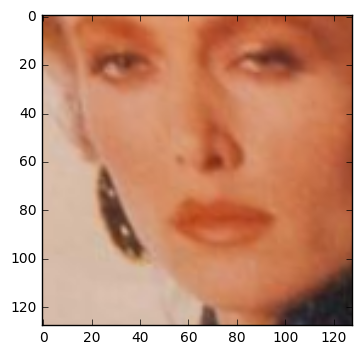

In [24]:
plt.imshow(to_rgb(people[0].imgs[0]))

In [14]:
from tensorflow.python.ops import array_ops
import tensorflow.contrib.layers as layers

def inception(net_in, kernel_stride, o1s, o2s1, o2s2, o3s1, o3s2, o4s1, o4s2, o4s3, name, is_training=True, bn_params={}, weight_decay=0.0, reuse=False):

    net = []
    
    with tf.variable_scope(name):
        with tf.contrib.framework.arg_scope([layers.convolution2d],
                                        padding='SAME', activation_fn=tf.nn.relu,
                                        normalizer_fn=layers.batch_norm, normalizer_params=bn_params,
                                        weights_initializer=layers.xavier_initializer_conv2d(),
                                        weights_regularizer=layers.l2_regularizer(weight_decay), reuse=reuse):
            with tf.variable_scope('branch1_1x1'):
                if o1s > 0:
                    net.append(layers.convolution2d(net_in, o1s, stride=1, kernel_size=1, scope='conv1x1'))
                
            with tf.variable_scope('branch2_3x3'):
                if o2s1 > 0:
                    conv3a = layers.convolution2d(net_in, o2s1, stride=1, kernel_size=1, scope='conv1x1')
                    conv3 = layers.convolution2d(conv3a, o2s2, stride=kernel_stride, kernel_size=3, scope='conv3x3')
                    net.append(conv3)

            with tf.variable_scope('branch3_5x5'):
                if o3s1 > 0:
                    conv5a = layers.convolution2d(net_in, o3s1, stride=1, kernel_size=1, scope='conv1x1')
                    conv5 = layers.convolution2d(conv5a, o3s2, stride=kernel_stride, kernel_size=5, scope='conv5x5')
                    net.append(conv5)

            with tf.variable_scope('branch4_pool'):
                pool = layers.max_pool2d(net_in, kernel_size=o4s1, stride=o4s3, padding='SAME', scope='pool')
                if o4s2 > 0:
                    pool =layers.convolution2d(pool, o4s2, stride=1, kernel_size=1, scope='conv1x1')
                net.append(pool)

            incept = array_ops.concat(3, net, name=name)
    return incept

def build_model(inputs, num_classes=128, keep_probability=0.75, is_training=True, reuse=None):
    weight_decay = 1e-3
    bn_params = {
        # Decay for the moving averages.
        'decay': 0.999,
        'center': True,
        'scale': True,
        # epsilon to prevent 0s in variance.
        'epsilon': 0.001,
        # None to force the updates during train_op
        'updates_collections': None,
        'is_training': is_training
    }

    with tf.contrib.framework.arg_scope([layers.convolution2d],
                                        padding='SAME', activation_fn=tf.nn.relu,
                                        normalizer_fn=layers.batch_norm, normalizer_params=bn_params,
                                        weights_initializer=layers.xavier_initializer_conv2d(),
                                        weights_regularizer=layers.l2_regularizer(weight_decay), reuse=reuse):
        net = layers.convolution2d(images, 64, stride=2, kernel_size=7, scope='conv1')
        net = layers.max_pool2d(net, kernel_size=3, stride=2, padding='SAME', scope='pool1')
        net = layers.convolution2d(net, 64, kernel_size=1, stride=1 ,scope='conv2')
        net = layers.convolution2d(net, 192, kernel_size=3, stride=1 ,scope='conv3')
        net = layers.max_pool2d(net, kernel_size=3, stride=2, padding='SAME', scope='pool3')
        
        net = inception(net, 1, 64, 96, 128, 16, 32, 3, 32, 1, 'incept3a', is_training, bn_params, weight_decay, reuse)
        net = inception(net, 1, 64, 96, 128, 32, 64, 3, 64, 1, 'incept3b', is_training, bn_params, weight_decay, reuse)
        net = inception(net, 2, 0, 128, 256, 32, 64, 3, 0, 2,  'incept3c', is_training, bn_params, weight_decay, reuse)

        net = inception(net, 1, 256, 96, 192, 32, 64, 3, 128, 1, 'incept4a', is_training, bn_params, weight_decay, reuse)
        net = inception(net, 2, 0, 160, 256, 64, 128, 3, 0, 2, 'incept4e', is_training, bn_params, weight_decay, reuse)

        net = inception(net, 1, 256, 96,  384, 0, 0, 3, 96,  1, 'incept5a', is_training, bn_params, weight_decay, reuse)
        net = inception(net, 1, 256, 96, 384, 0, 0, 3, 96, 1, 'incept5b', is_training, bn_params, weight_decay, reuse)

        net = layers.avg_pool2d(net, kernel_size=3, stride=1, padding='VALID', scope='pool6')
        net = tf.reshape(net, [-1, 736], name='prelogits')
        net = tf.nn.dropout(net, keep_probability)
        net = layers.fully_connected(net, num_classes, weights_initializer=layers.xavier_initializer(), scope='fc7', reuse=reuse)
        
        net = tf.nn.l2_normalize(net,1,1e-10, name="embeddings")
        return net

In [16]:
class FaceNet:
    def __init__(self):
        """
        :param input_shape: [batch_size, H, W, channels]
        :param num_classes: number of different classes
        """
        self.x = tf.placeholder(tf.float32, [None, 128, 128, 3], name='X')

        self.embeddings = build_model(self.x)
        
        anchor, pos, neg = tf.split(0,3,self.embeddings)
        
        self.triplet_loss = triplet_loss(anchor, pos, neg)
        
        regularization_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        self.loss = tf.add_n([self.triplet_loss] + regularization_losses, name='loss')

        self.train_op = tf.train.AdamOptimizer().minimize(self.loss)

        self.eval_embeddings = build_model(self.x, 128, 0.75, False, True)
        
        anchor, pos, neg = tf.split(0,3,self.eval_embeddings)
        self.eval_triplet_loss = triplet_loss(anchor, pos, neg)
        regularization_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        self.eval_loss = tf.add_n([self.eval_triplet_loss] + regularization_losses, name='eval_loss')

        self.session = tf.Session()
        self.session.run(tf.initialize_all_variables())

    def train(self, x):
        run_ops = [self.train_op, self.loss]
        feed_dict = {self.x: x}
        return self.session.run(run_ops, feed_dict=feed_dict)

    def eval(self, x):
        feed_dict = {self.x: x}
        return self.session.run([self.eval_embeddings, self.eval_loss], feed_dict=feed_dict)